In [0]:
import torch
import torchvision.transforms as trans
import torchvision.datasets as dsets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class SGD:
  def __init__(self,parameters,lr,momentum=0.0):
    self.x_state = list(parameters)
    self.lr = lr
    self.momentum = momentum
    self.v_states = [t.data.clone().zero_() for t in self.x_state]

  def zero_grad(self):
    for x in self.x_state:
      if x.grad is not None:
        x.grad.data.zero_()

  def step(self):
    for x,v in zip(self.x_state,self.v_states):
      g = x.grad.data
      v.mul_(self.momentum).add_(g)
      x.data.add_(v.mul_(-self.lr))


In [5]:
trainset = dsets.MNIST(root='../data/mnist',train=True,transform=trans.ToTensor(),download=True)
testset = dsets.MNIST(root='../data/mnist',train=False,transform=trans.ToTensor(),download=True)
train_loader = DataLoader(trainset,batch_size=128,shuffle=True,num_workers=6)
test_loader = DataLoader(testset,batch_size=128,shuffle=False,num_workers=6)


Extracting ../data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw


Extracting ../data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw


Extracting ../data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/mnist/MNIST/raw


Extracting ../data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/mnist/MNIST/raw
Processing...



Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
def eval(model,criterion,dataloader):
  loss,acc = 0,0
  for bx,by in dataloader:
    bx = bx.view(-1,784)
    logit = model(bx)
    err = criterion(logit,by)
    loss += err.item()
    _,pred_y = logit.max(dim=1)
    acc += (pred_y.data==by).float().sum()/bx.size(0)

  loss /= len(dataloader)
  acc /= len(dataloader)
  return loss,acc


In [18]:
model = nn.Sequential(nn.Linear(784,500),nn.ReLU(),nn.Linear(500,300),nn.ReLU(),
                      nn.Linear(300,10))
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(),0.1,momentum=0.9)
train_history = []
nepoch = 30
for epoch in range(nepoch):
  for bx,by in train_loader:
    bx = bx.view(-1,784)
    logit = model(bx)
    err = criterion(logit,by)
    err.backward()
    optimizer.step()
    optimizer.zero_grad()
  loss,acc = eval(model,criterion,train_loader)
  loss1,acc1 = eval(model,criterion,test_loader)
  print("[%3d/%d] |\t train_error:%.1e,train_acc:%.2f |\t test_error:%.1e,test_acc:%.2f"%(
      epoch+1,nepoch,loss,acc,loss1,acc1
  ))
  train_history.append((loss,acc,loss1,acc1))

[  1/30] |	 train_error:3.1e-01,train_acc:0.91 |	 test_error:3.0e-01,test_acc:0.91
[  2/30] |	 train_error:2.4e-01,train_acc:0.93 |	 test_error:2.3e-01,test_acc:0.93
[  3/30] |	 train_error:1.7e-01,train_acc:0.95 |	 test_error:1.7e-01,test_acc:0.95
[  4/30] |	 train_error:1.4e-01,train_acc:0.96 |	 test_error:1.4e-01,test_acc:0.96
[  5/30] |	 train_error:1.1e-01,train_acc:0.97 |	 test_error:1.2e-01,test_acc:0.96
[  6/30] |	 train_error:8.8e-02,train_acc:0.98 |	 test_error:9.9e-02,test_acc:0.97
[  7/30] |	 train_error:8.2e-02,train_acc:0.98 |	 test_error:9.8e-02,test_acc:0.97
[  8/30] |	 train_error:7.0e-02,train_acc:0.98 |	 test_error:9.2e-02,test_acc:0.97
[  9/30] |	 train_error:5.7e-02,train_acc:0.98 |	 test_error:7.9e-02,test_acc:0.98
[ 10/30] |	 train_error:5.0e-02,train_acc:0.99 |	 test_error:7.8e-02,test_acc:0.97
[ 11/30] |	 train_error:4.3e-02,train_acc:0.99 |	 test_error:7.0e-02,test_acc:0.98
[ 12/30] |	 train_error:4.0e-02,train_acc:0.99 |	 test_error:7.2e-02,test_acc:0.98
[ 13

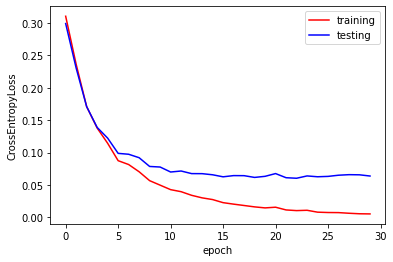

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([t[0] for t in train_history],'r',label='training')
plt.plot([t[2] for t in train_history],'b',label='testing')
plt.xlabel('epoch')
plt.ylabel('CrossEntropyLoss')
plt.legend()